# Australian Rainfall

## Get the Data

The dataset used in this notebook can be found on Kaggle at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package. It contains "about 10 years of daily weather observations from many locations across Australia". 

Our objective is to derive a model that predicts if it will or will not rain the next day, given weather observations for a given location on a given day. 

The dataset contains observations for 23 variables. For each instance, the location and date are given, along with 19 weather metrics. These 19 metrics are mostly continuous, for example minimum and maximum temperature (measured in Celsius) or sky coverage (measured in eights (so a low precision scale of observation)), and three "cyclic" variables in the case of wind speed direction at 9AM and 3PM respectively and the direction of the strongest wind-gust (encoded as strings in this raw dataset). As well of these weather metrics, there are two binary variables indicating if it rained that day and if it rained the next day. "RainTomorrow" will act as our response variable (i.e. the associated "label" of each instance).

We begin by importing some key packages and loading our weather data into a pandas dataframe:

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
aus_weather_df = pd.read_csv('weatherAUS.csv') #Load the Australian Weather Data (will be dependent upon .csv location)
aus_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We notice right away that the number of missing values (i.e. null values) varies wildly between features, and we will revisit this in the "Preparing the Data" section.

Let us also check how attributes of dtype "Object" are encoded:

In [166]:
aus_weather_df.select_dtypes('object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,E,SE,ENE,No,No
145456,2017-06-22,Uluru,NNW,SE,N,No,No
145457,2017-06-23,Uluru,N,SE,WNW,No,No
145458,2017-06-24,Uluru,SE,SSE,N,No,No


Lets check the type of the first entry in each of these columns (from the above we know it is non-null).

In [167]:
object_dtype_columns = aus_weather_df.select_dtypes('object').columns.values
for col in object_dtype_columns:
    print(type(aus_weather_df[col][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


We see that that all these values are strings (which we could have infered by the data being from a .csv file).

For now, "string" is a suitable type for most of these values at this, but we will revisit this in the "Preparation of Data for Machine Learning" section.

However, let us convert the data in our "Date" column to "datatime" format for the convenient computational properties of encoding dates in this way (in pandas the values in the column will have python type "pandas.Timestamp", which is designed to mimic the "datetime.datetime" class).

In [168]:
aus_weather_df['Date'] = pd.to_datetime(aus_weather_df['Date'])

### Getting Geographic Data
Usually with a Kaggle dataset, getting the data happens in a single step. That is you simply get the .csv file and you're done. However, since it is often necessary to assemple a dataset from various sources in most machine learning projects in practical settings, I decided to expand this dataset slightly. 

In this dataset locations are given as a single string identifying a weather station in Australia by its name. Since weather will naturally be influenced by geographic location, it could be beneficial to include the latitude and longitude of the location for which each observation was made in our model. This puts location onto a geographic scale which could help our model (in combination with the catagorical observations of location).

I searched online for geagraphic data on Australian cities and found a "free to use" "Australian Cities" database which can be downloaded at https://simplemaps.com/data/au-cities.

It gives the names, latitudes, longitudes, and other attributes, for 1035 Australian cities. 

In [169]:
aus_geo_data_df = pd.read_csv('au.csv') #Load geographic for australia data (after downloading)

We would like a unique latitude and longitude for each city-location in our Australian weather data. Therefore we should inspect this Australian cities dataset to see if there are any missing values or surprises.

In [170]:
aus_geo_data_df.isnull().sum(axis = 0) #Count the number of null values for each column

city                    0
lat                     0
lng                     0
country                 0
iso2                    0
admin_name              0
capital              1026
population              0
population_proper       0
dtype: int64

We are only interested in latitude and longitude, so there are no missing values in the data of interest.

We now check for duplicate rows:

In [171]:
aus_geo_data_df.duplicated().sum()

0

Next we check for multiple occurences of cities with the same name, as we need a unique latitude and longitude value for each city in our Australian weather data.

In [172]:
aus_geo_data_df['city'].value_counts()

Mount Barker        2
Perth               2
Longford            2
Emerald             2
Richmond            2
                   ..
Craignish           1
Woodford            1
Wurruk              1
Katherine           1
Fitzroy Crossing    1
Name: city, Length: 1026, dtype: int64

We find that some cities appear twice in the database.
Inspecting the latitude and longitude values of "Richmond" specifically:

In [173]:
aus_geo_data_df[aus_geo_data_df['city'] == 'Richmond']

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
253,Richmond,-33.5983,150.7511,Australia,AU,New South Wales,NaN,5482,5482
793,Richmond,-42.7336,147.4394,Australia,AU,Tasmania,NaN,1464,1464


We see that there are two cities at different locations named "Richmond". 

We now chack which cities in this australian cities dataset correspond to locations in our australian weather dataset, and we then check if any of these cities correspond to multiple locations (i.e. there are multiple cities in Australia that share this name).

In [174]:
weather_locations_s = pd.Series(aus_weather_df['Location'].unique()) #Series of unique locations in weather data
city_in_weather_data = aus_geo_data_df['city'].isin(weather_locations_s)
cities_in_weather_data = aus_geo_data_df['city'][city_in_weather_data] #Cities in both weather data and Australian cities data
cities_in_weather_data.value_counts()

Richmond      2
Perth         2
Townsville    1
Launceston    1
Sydney        1
Cobar         1
Mildura       1
Nuriootpa     1
Hobart        1
Darwin        1
Sale          1
Newcastle     1
Melbourne     1
Katherine     1
Penrith       1
Wollongong    1
Moree         1
Canberra      1
Adelaide      1
Portland      1
Cairns        1
Bendigo       1
Albury        1
Albany        1
Ballarat      1
Brisbane      1
Name: city, dtype: int64

In [175]:
print(cities_in_weather_data.unique().size)
print(weather_locations_s.size)

26
49


We find that there is weather data for "Perth" and "Richmond" and that these two cities each correspond to two locations. 

We also find that Cities account for 26 out of 49 locations in our australian weather data.

At this point we would need to contact the provider of the australian weather data to find out which "Perth" and which "Richmond" their weather observations refer to. Since this is an exercise, we imagine that the cities of interest correspond to the first first occurence of each city in the Australian cities data. 

We use a "group-by" to transform the cities data in this way.

In [176]:
aus_geo_data_df = aus_geo_data_df.groupby('city', as_index = False).first()
aus_geo_data_df['city'].value_counts() #The value counts verify that there is now a unique location for each city

Wauchope           1
Newcastle          1
Raymond Terrace    1
Robe               1
Sanctuary Point    1
                  ..
Katherine          1
Mollymook          1
Henty              1
Kwinana            1
Indented Head      1
Name: city, Length: 1026, dtype: int64

We now use the `merge` method to join our our australian weather data with our data on australian city locations, by joining along the 'Location' and 'city' columns for the respective datasets.

In [177]:
city_to_coord_df = aus_geo_data_df[['city', 'lat', 'lng']] #Dataframe containing only city name and latitude/longitude

Now we turn our attention to locations that are not cities (according to the names given in the previos dataset at least).

In [178]:
non_city = ~weather_locations_s.isin(cities_in_weather_data)
non_city_locations = weather_locations_s[non_city]
non_city_locations.size

23

I fill in coordinates for the remaining locations manualy with the help of Google search.

Note: This could have been automated, but would still have required additional information to be researched and provided as existing packages rely upon a full address to derive coordinates. Since there are only 23 locations to lookup it is not too time consuming to enter them manually. Also, as we would expect new data to belong to one of the existing locations it does not seem necessary to automate this process, as we do not expect to have to expand upon this in the future (although it is always best to seek to automate efficiently). And finally, since the purpose of this project is to practice machine learning and the associated considerations it seemes unnecessary to dedicate substantial time to learning new packages for this purpose. If there were hundreds of locations then automating this process would certainly be necessary (if the locations gave enough information to effectively do so).

In [179]:
location_coord_df = pd.DataFrame(np.array([['BadgerysCreek', - 33.8829, 150.7609], ['CoffsHarbour', - 30.2986, 153.1094],
 ['NorahHead',- 33.2833, 151.5667], ['NorfolkIsland',- 29.0408, 167.9547],  
 ['SydneyAirport',- 33.9399, 151.1753], ['WaggaWagga',- 35.1082, 147.3598],
 ['Williamtown',- 32.8150, 151.8428],  ['Tuggeranong',- 35.4244 , 149.0888],
 ['MountGinini',- 35.5294 , 148.7723], ['MelbourneAirport',- 37.6690 , 144.8410],
 ['Nhil',- 36.3328, 141.6503],  ['Watsonia',- 37.7080, 145.0830],
 ['Dartmoor',- 37.9144, 141.2730], ['GoldCoast', - 28.0167, 153.4000],
 ['MountGambier',- 37.8284, 140.7804],  ['Woomera',- 31.1656, 136.8193],
 ['Witchcliffe',- 34.0168, 115.0973], ['PearceRAAF',- 31.6676, 116.0292],
 ['PerthAirport',- 31.9385, 115.9672],  ['SalmonGums',- 32.9815, 121.6438],
 ['Walpole',- 34.9777, 116.7338] ,  ['AliceSprings',- 23.6980 , 133.8807],
 ['Uluru',- 25.3444, 131.0369]]), columns = ['Location','lat','lng'])

city_to_coord_df.rename(columns = {'city' : 'Location'}, inplace = True) #Rename city column as Location for dataframe concatination
location_coord_df = pd.concat([city_to_coord_df, location_coord_df]) #Dataframe of all weather locations and their latitude/longitude

C:\Users\44749\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Now we add these coordinates to our weather dataframe. We accomplish this using the merge method, which allows us to join our australian weather data with our `city_to_coord_df` dataframe along the "Location" column.

In [207]:
aus_weather_geo_df = aus_weather_df.merge(right = location_coord_df, how = 'left'
                                 , on = 'Location')
aus_weather_geo_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,lat,lng
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.0806,146.9158
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.0806,146.9158
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.0806,146.9158
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.0806,146.9158
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.0806,146.9158


Now we can plot our weather locations using their coordinates of latitude and longitude:

Text(0.5, 1.0, 'Spacial distribution of weather stations')

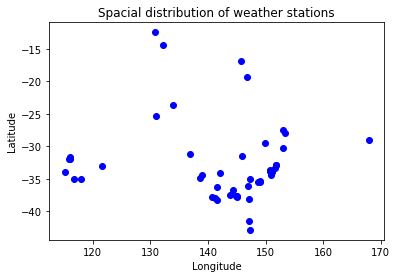

In [181]:
weather_loc_indices = location_coord_df['Location'].isin(weather_locations_s)
weather_locations = location_coord_df[weather_loc_indices]
plt.plot(weather_locations['lng'], weather_locations['lat'], 'bo')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spacial distribution of weather stations')

### On Missing Values
We will hands missing values in our "Preparation of Data for Machine Learning" section. However, we must examine the distribution of missing values a little before we split our data into a test set and training set, as otherwise we run the risk of ending up with a test set that contains almost no "complete" observations, which would detract from the validity of our generalisation error estimate.

Therefore, let us examine the percentage of missing values for each feature and how these missing values depend upon location:

In [182]:
no_missing_values = aus_weather_df.isnull().sum(axis = 0) # Create series encoding number of missing values for each column
no_missing_values.sort_values(ascending = False)/len(aus_weather_df)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

We see that the features Sunshine, Evaporation, Cloud3pm, and Cloud9am all have at least 38% missing values. 

Now let us look at how missing values depend upon location:

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,0,2,2,70,1441,1392,23,23,259,15,...,5,5,8,7,3090,3090,5,4,70,0
Albany,0,59,32,20,280,506,3016,3016,244,767,...,46,700,25,24,35,695,36,696,20,0
Albury,0,6,1,20,3011,3011,10,10,517,42,...,4,4,0,4,1729,1596,4,4,20,0
AliceSprings,0,1,1,6,211,511,50,50,230,4,...,3,5,1,3,332,358,0,2,6,0
BadgerysCreek,0,12,3,51,2928,2928,16,16,395,60,...,29,31,143,148,2928,2928,16,20,51,0


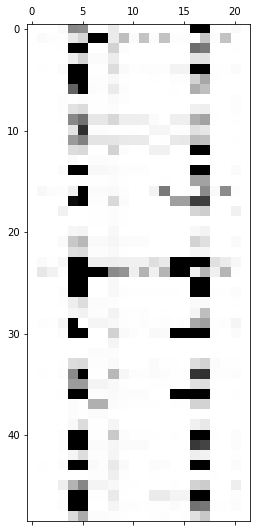

In [208]:
location_index = aus_weather_df['Location']
aus_weather_df[location_index == 'Canberra']
a = aus_weather_df.isnull()
a['Location'] = aus_weather_df['Location']
plt.matshow((a.groupby('Location').sum())/(a.groupby('Location').count()), cmap = 'binary')
((a.groupby('Location').sum())).head()

We see that the majority of missing values occur for particular features in specific locations. Since we will use stratified sampling based upon location, the proportion of missing values in our train and test set should be similar.

We should also discard any observations for which no observation exists for "RainTomorrow":

In [189]:
aus_weather_df.dropna(subset = ['RainTomorrow'], inplace = True)
aus_weather_df.reset_index(drop = True, inplace = True)

### Train Test Split
We are now ready to split our data into a training set and a test set. We will use stratified sampling to preserve the proportions of locations in the training data.

In [191]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
for train_index, test_index in split.split(aus_weather_df, aus_weather_df['Location']):
    train_set = aus_weather_df.loc[train_index]
    test_set = aus_weather_df.loc[test_index]

## Explore the Data
We now perform some exploratory data analysis on the training set.

In [192]:
weather = train_set.copy()

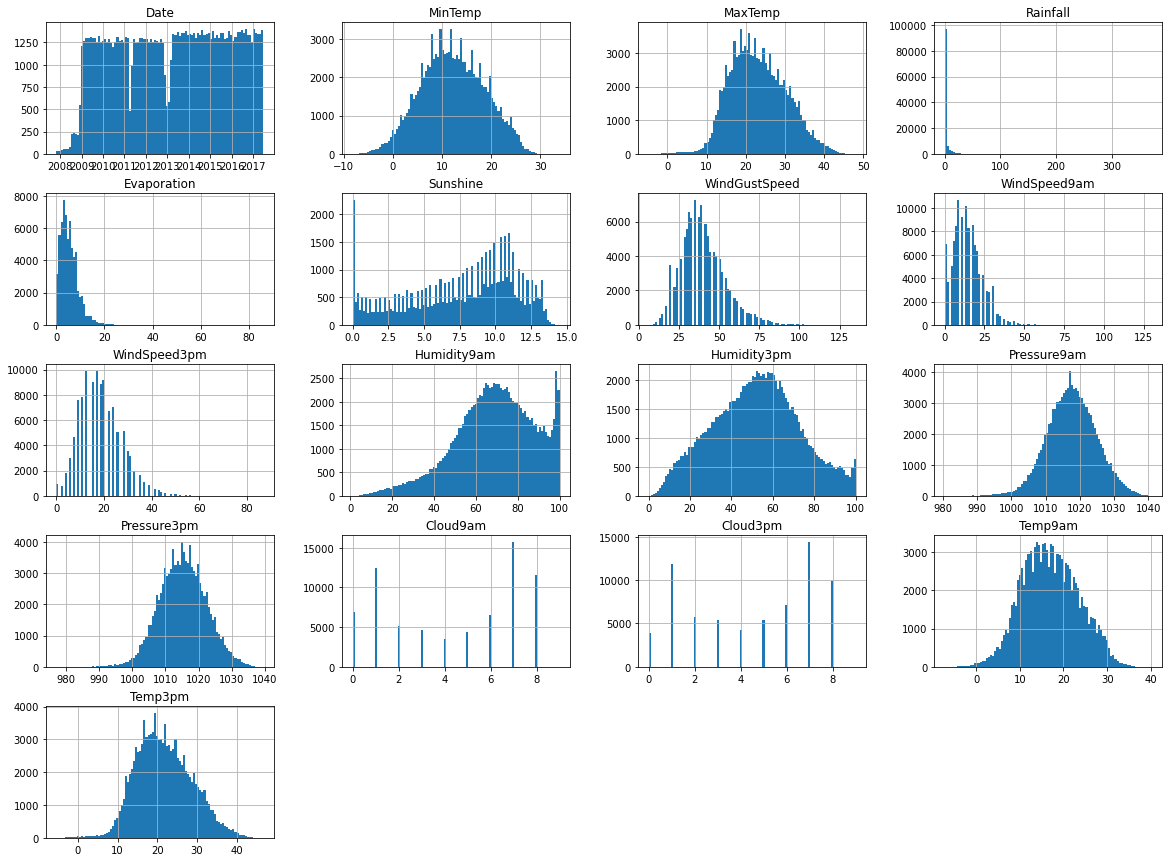

In [195]:
weather.hist(bins = 100, figsize = (20, 15))
pass

We see that Humidity9am and Humidity3pm appear to be capped at 100. Humidity of 100 means that the air is saturated with water vapour and has reached its "dew point" (https://en.wikipedia.org/wiki/Humidity) (I am infering that these humidty readings are for "relative humidity", since they are given on a percent scale) . Therefore this is a natural maximum, and not a result of instrumental limitations (although it is a limitation of relative humidity as a metric to record all information, absolute humidity may have been more predictively useful).

We have many zero values for Rainfall, Evaporation, and Sunshine. In all of these cases it might be valuable to add an additional binary variable to indicate if an observation is at the maximum/minimum.

## Prepare the Data

Before using this data in an ML model, we must endcode all of our attributes in effective formats. We must decide how we will handle missing values, and we must decide if there are any additional features that we wish to add that could be of benefit to the model. This whole process should be done in such a way that it can be automated, so that when new data becomes available we do not need to manually repeat all of these steps. We construct a simple data preprocess "pipeline" for this purpose.

### Missing Values

In [26]:
no_missing_values = aus_weather_df.isnull().sum(axis = 0) # Create series encoding number of missing values for each column
no_missing_values.sort_values(ascending = False)/len(aus_weather_df)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
Rainfall         0.022419
RainToday        0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
Location         0.000000
Date             0.000000
dtype: float64

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,0.0,0.000626,0.000940,0.031945,0.466333,0.445976,0.008143,0.008143,0.085813,0.005011,...,0.001566,0.001566,0.002505,0.002192,1.000000,1.000000,0.001566,0.001253,0.031945,0.032258
Albany,0.0,0.020724,0.017763,0.007895,0.095395,0.171053,1.000000,1.000000,0.081250,0.257566,...,0.016118,0.235526,0.008224,0.008224,0.012500,0.233882,0.012829,0.234211,0.007895,0.007895
Albury,0.0,0.003618,0.003618,0.009539,1.000000,1.000000,0.010526,0.010526,0.172697,0.015132,...,0.002961,0.002632,0.001645,0.002632,0.575987,0.530592,0.002961,0.002632,0.009539,0.009539
AliceSprings,0.0,0.000329,0.000658,0.002632,0.070724,0.171053,0.016776,0.016776,0.075658,0.001316,...,0.000987,0.001645,0.000329,0.000987,0.109868,0.118750,0.000000,0.000658,0.002632,0.002961
BadgerysCreek,0.0,0.011964,0.009638,0.026919,1.000000,1.000000,0.025258,0.025258,0.144566,0.028249,...,0.017946,0.018278,0.055833,0.057494,1.000000,1.000000,0.013626,0.014623,0.026919,0.026919
Ballarat,0.0,0.000329,0.000329,0.003947,1.000000,1.000000,0.010197,0.010197,0.029934,0.005921,...,0.006908,0.002303,0.007895,0.008553,0.179605,0.344737,0.003947,0.001974,0.003947,0.003947
Bendigo,0.0,0.000658,0.001645,0.001974,0.610197,1.000000,0.013487,0.013158,0.080263,0.014145,...,0.002303,0.000658,0.004934,0.003289,0.318421,0.253947,0.000987,0.000658,0.001974,0.001974
Brisbane,0.0,0.002819,0.004385,0.010022,0.005951,0.015346,0.012841,0.012841,0.021923,0.010648,...,0.001253,0.004698,0.000313,0.002505,0.000313,0.000626,0.001253,0.004698,0.010022,0.010022
Cairns,0.0,0.000329,0.000000,0.017105,0.121711,0.156579,0.006250,0.005921,0.014145,0.001316,...,0.000329,0.000000,0.000329,0.000000,0.068092,0.075658,0.000329,0.000000,0.017105,0.017105


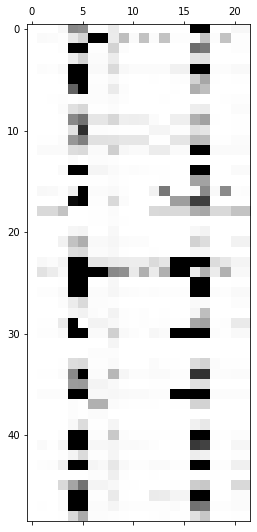

In [52]:
location_index = aus_weather_df['Location']
aus_weather_df[location_index == 'Canberra']
a = aus_weather_df.isnull()
a['Location'] = aus_weather_df['Location']
plt.matshow((a.groupby('Location').sum())/(a.groupby('Location').count()), cmap = 'binary')
((a.groupby('Location').sum())/(a.groupby('Location').count()))

We see from this that there are several locations for which no observations exist at all for the 4 variables Sunshine, Evaporation, Cloud3pm, and Cloud9am. Given this and the fact that these features each have at least 38% missing values we remove these 4 features. or could maybe interpolate again using locations? (or too little information to interpolate)    
We do have that WindGustDir 	WindGustSpeed have no observations for "Albany" and "Newcastle" - could interpolate using location (as have many more observations). There are also several locations with no observations for Pressure9am and Pressure3pm

In [28]:
col_names = aus_weather_df.columns.values #numpy array of column names
missing_values = pd.DataFrame()
for col_name in col_names:
    no_null = aus_weather_df.loc[:,col_name].isnull().sum() #Number of missing values for named column in aus_weather_df
    missing_values[col_name] = pd.Series(no_null)
missing_values

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,0,1485,1261,3261,62790,69835,10326,10263,10566,...,2654,4507,15065,15028,55888,59358,1767,3609,3261,3267


In [29]:
aus_weather_df['Location'].value_counts()

Canberra            3436
Sydney              3344
Melbourne           3193
Perth               3193
Brisbane            3193
Hobart              3193
Adelaide            3193
Darwin              3193
Albany              3040
AliceSprings        3040
Ballarat            3040
Albury              3040
Townsville          3040
Launceston          3040
Wollongong          3040
MountGambier        3040
Cairns              3040
MountGinini         3040
GoldCoast           3040
Bendigo             3040
Newcastle           3039
Penrith             3039
Tuggeranong         3039
Nuriootpa           3009
Richmond            3009
CoffsHarbour        3009
PearceRAAF          3009
BadgerysCreek       3009
PerthAirport        3009
Watsonia            3009
MelbourneAirport    3009
Moree               3009
SydneyAirport       3009
Mildura             3009
WaggaWagga          3009
NorfolkIsland       3009
Portland            3009
Witchcliffe         3009
Cobar               3009
Williamtown         3009


In [99]:
dates_pd = pd.DataFrame()
    
dates_s = pd.to_datetime(aus_weather_df['Date'])

dates_pd['Date'] = dates_s
dates_pd['Day of Year'] = dates_s.apply(lambda date : date.day_of_year)
dates_pd['Year'] = dates_s.apply(lambda date : date.year)
dates_pd['Leap Year'] = dates_s.apply(lambda date : date.is_leap_year)
dates_pd['Leap Year']
dates_pd['Day_x'] = 0
dates_pd['Day_y'] = 0
dates_pd['Day of Year'][dates_pd['Leap Year'] == 1] = dates_pd['Day of Year'][dates_pd['Leap Year'] == 1]/366
dates_pd['Day of Year'][dates_pd['Leap Year'] == 0] = dates_pd['Day of Year'][dates_pd['Leap Year'] == 0]/365

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


<ipython-input-99-dce771b65aef>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_pd['Day of Year'][dates_pd['Leap Year'] == 1] = dates_pd['Day of Year'][dates_pd['Leap Year'] == 1]/366


,Date,Day of Year,Year,Leap Year,Day_x,Day_y
0,2008-12-01,0.918033,2008,True,0.870285,-0.492548
1,2008-12-02,0.920765,2008,True,0.878612,-0.477536
2,2008-12-03,0.923497,2008,True,0.886680,-0.462383
3,2008-12-04,0.926230,2008,True,0.894487,-0.447094
4,2008-12-05,0.928962,2008,True,0.902030,-0.431673
...,...,...,...,...,...,...
145455,2017-06-21,0.471233,2017,False,-0.983709,0.179767
145456,2017-06-22,0.473973,2017,False,-0.986658,0.162807
145457,2017-06-23,0.476712,2017,False,-0.989314,0.145799
145458,2017-06-24,0.479452,2017,False,-0.991677,0.128748


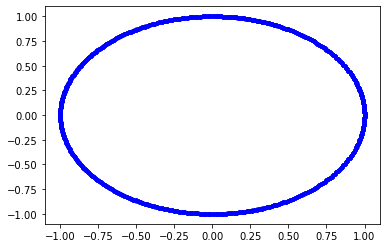

In [114]:
dates_pd['Day_x'] = np.cos(2 * np.pi * dates_pd['Day of Year'])
dates_pd['Day_y'] = np.sin(2 * np.pi * dates_pd['Day of Year'])
plt.plot(dates_pd[aus_weather_df['Location'] == 'Albury']['Day_x'], dates_pd[aus_weather_df['Location'] == 'Albury']['Day_y'], 'b.')
dates_pd

In [113]:
aus_weather_df['WindGustDir'].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', nan, 'ENE',
       'SSE', 'S', 'NW', 'SE', 'ESE', 'E', 'SSW'], dtype=object)